<a href="https://colab.research.google.com/github/arifeensaeed99/bins-sms-app/blob/main/COVID_19_Time_Series_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By: Arifeen Saeed

About the data:
A Kaggle dataset with cumulative data on US counties, states, and more regarding COVID-19 cases and deaths over time, derived from the New York Time's GitHub CSV via a realtime source: https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv). Data is compiled from state and local governments to provide an ongoing record in realtime, and goes up to May 12, 2022. The dataset has over 2.5 million rows of data and is about 100 megabytes.

Inspiration: 
I decided to devote my weekend to learning Time Series forecasting. I studied a case where machine learning is used to forecast energy consumption, in the following video: https://www.youtube.com/watch?v=vV12dGe_Fho&feature=youtu.be
I adopt the methodologies to my case. The goal of my project is to predict US COVID-19 deaths using time series data using XGBoost.

In [1]:
# the necessary import statements
import pandas as pd
import numpy as np #
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv('/us-counties.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

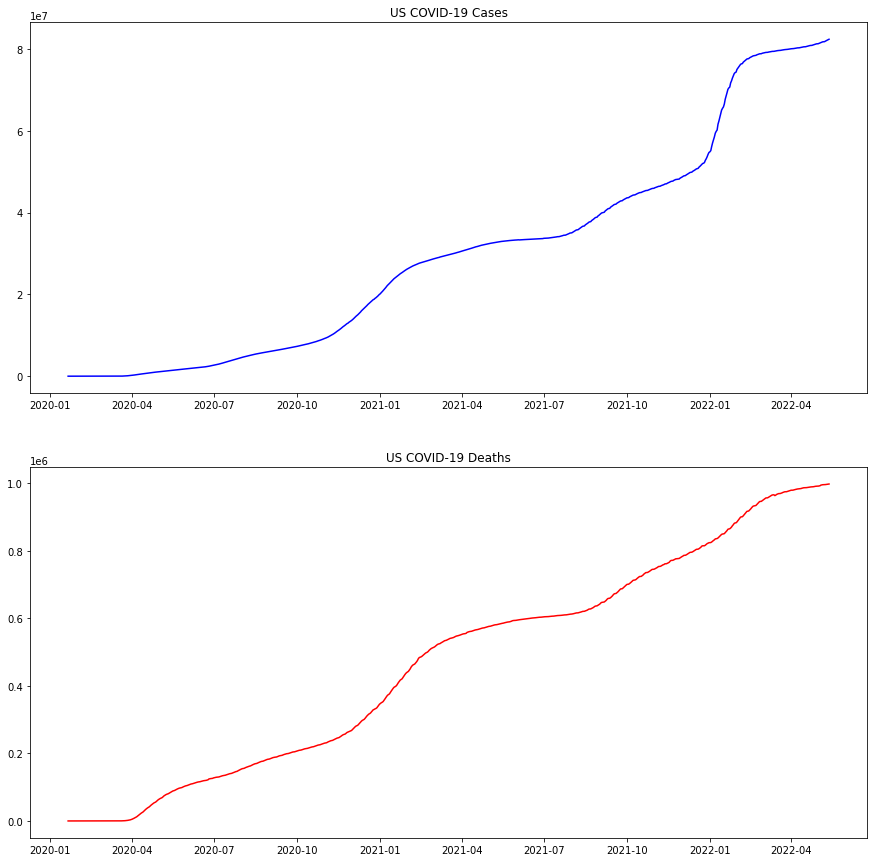

In [14]:
# Seeing COVID Cases and Deaths in the US
fig, (ax1, ax2) = plt.subplots(2, figsize = (15, 15))
ax1.plot(df['cases'].index.unique(), df['cases'].groupby(df['cases'].index).sum(), color='b')
ax1.title.set_text('US COVID-19 Cases')
ax2.plot(df['deaths'].index.unique(), df['deaths'].groupby(df['deaths'].index).sum(), color='r')
ax2.title.set_text('US COVID-19 Deaths')

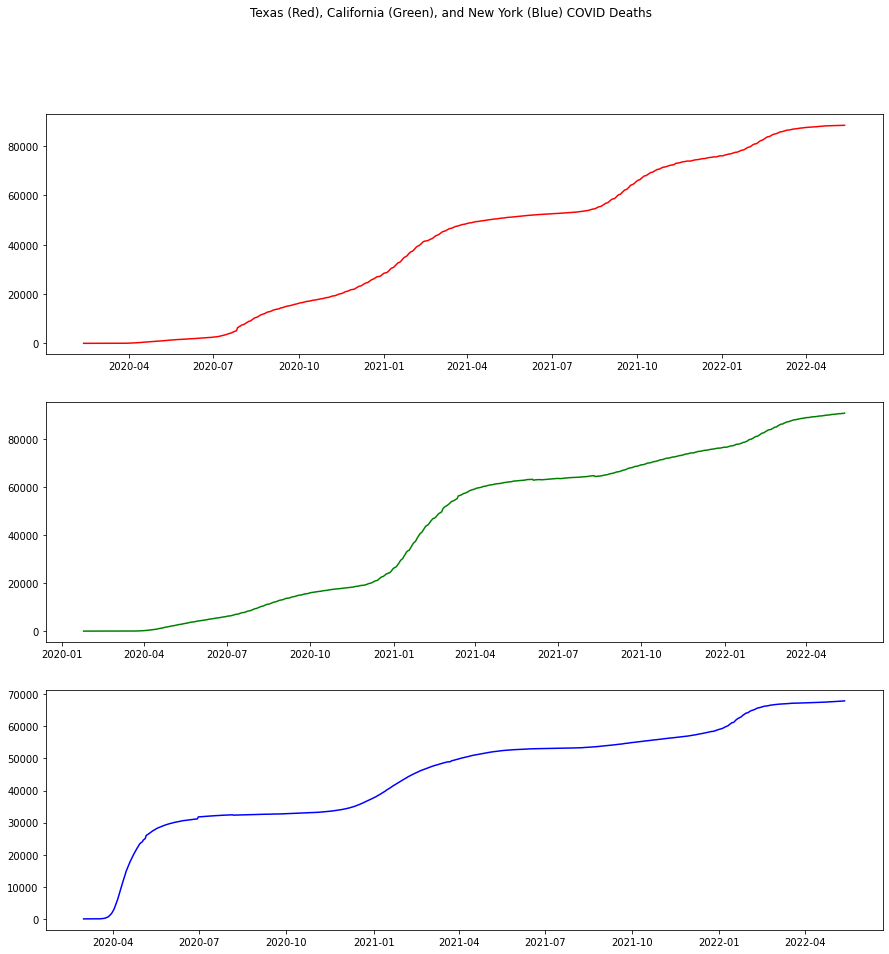

In [15]:
# Seeing Data for Large States
texas_df = df[df['state'] == 'Texas']
california_df = df[df['state'] == 'California']
new_york_df = df[df['state'] == 'New York']

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (15, 15))
fig.suptitle('Texas (Red), California (Green), and New York (Blue) COVID Deaths')
ax1.plot(texas_df['deaths'].index.unique(), texas_df['deaths'].groupby(texas_df['deaths'].index).sum(), color='r')
ax2.plot(california_df['deaths'].index.unique(), california_df['deaths'].groupby(california_df['deaths'].index).sum(), color='g')
ax3.plot(new_york_df['deaths'].index.unique(), new_york_df['deaths'].groupby(new_york_df['deaths'].index).sum(), color='b')


In [16]:
# Adding time series features
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df = create_features(df)

In [17]:
# Dropping NAs and using the log of death for scaling
df = df.dropna()
df['log_deaths'] = np.log(df.deaths)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-17-5942e58313a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_deaths'] = np.log(df.deaths)


Text(0.5, 1.0, 'US COVID-19 log_Deaths by Month')

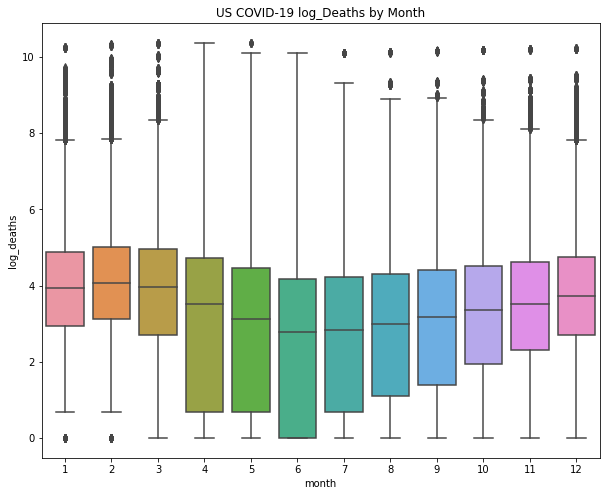

In [19]:
# Visualize Feature / Target Relationships Example
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='log_deaths')
ax.set_title('US COVID-19 log_Deaths by Month')

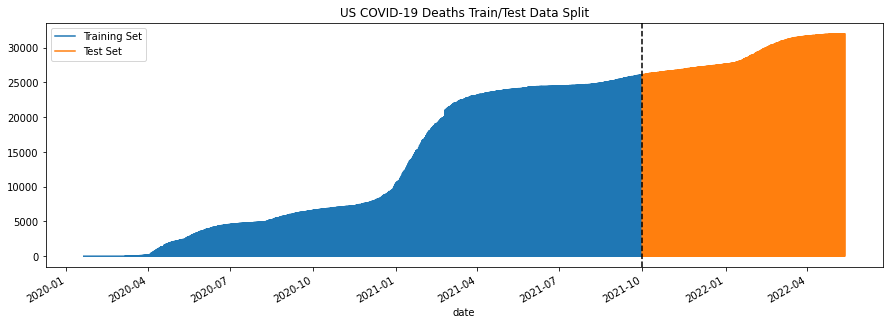

In [21]:
# Train Test Visualization
train = df['deaths'].loc[df['deaths'].index < '2021-10-01']
test = df['deaths'].loc[df['deaths'].index >= '2021-10-01']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = "Training Set", title = "US COVID-19 Deaths Train/Test Data Split")
test.plot(ax=ax, label = 'Test Set')
ax.axvline('2021-10-01', color='black', ls = '--')
ax.legend(['Training Set', 'Test Set'])

In [22]:
# Creating the ML Model (using time series features ONLY - memory)
train = df.loc[df.index < '2021-10-01']
test = df.loc[df.index >= '2021-10-01']

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'fips']
TARGET = 'deaths'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [25]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=200,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=1) # optimized
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[13:22:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:463.685	validation_1-rmse:852.013
[100]	validation_0-rmse:180.806	validation_1-rmse:412.868
[199]	validation_0-rmse:140.023	validation_1-rmse:389.479


XGBRegressor(early_stopping_rounds=50, learning_rate=1, n_estimators=200)

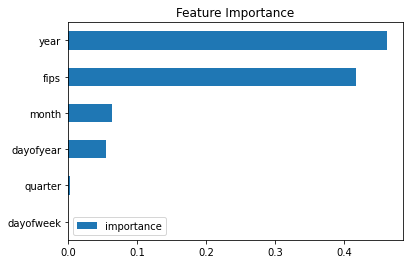

In [27]:
# Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<ipython-input-28-68fb62897437>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


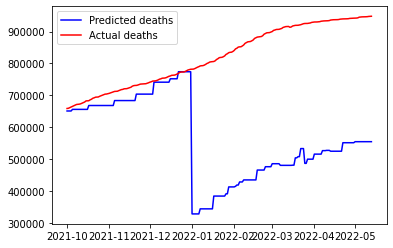

In [28]:
# Forecasting on Test
test['prediction'] = reg.predict(X_test)

plt.plot(test.index.unique(), test['prediction'].groupby(test['prediction'].index).sum(), label = 'Predicted deaths', color = 'b')
plt.plot(test.index.unique(), test['deaths'].groupby(test['deaths'].index).sum(), label = 'Actual deaths', color = 'r')
plt.legend()
plt.show()

In [29]:
# Score RMSE
score = np.sqrt(mean_squared_error(test['deaths'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 389.66


In [31]:
# Worst and best predicted days
test['error'] = np.abs(test['deaths'] - test['prediction'])
test['date'] = test.index.date
test.groupby(test.date)['error'].mean().sort_values(ascending=False).head(10)

<ipython-input-31-d6d2063ccb9f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test['deaths'] - test['prediction'])
<ipython-input-31-d6d2063ccb9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index.date


date
2022-05-13    166.354821
2022-05-12    166.252020
2022-05-11    166.179136
2022-05-10    165.996230
2022-05-09    165.916981
2022-05-08    165.872622
2022-05-07    165.865299
2022-05-06    165.852564
2022-05-05    165.757690
2022-04-21    165.635532
Name: error, dtype: float64

In [32]:
# Next steps
# More features: holidays, add county, state data with RAM and deep learning